C:\Users\HP\AppData\Local\Temp\ipykernel_28188\1826049994.py:6: DtypeWarning: Columns (13,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/processed/race_result_cleaned.csv')


=== 1. Cek Distribusi Target (Rank) ===


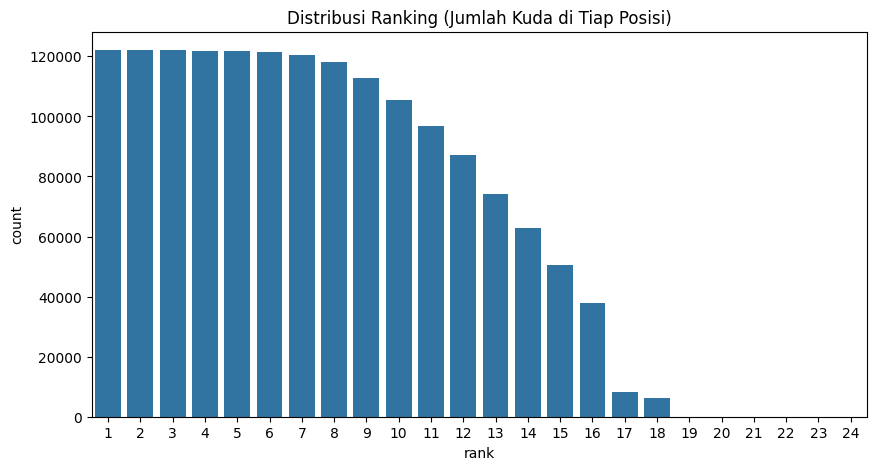

=== 2. Cek Hubungan Odds vs Rank ===


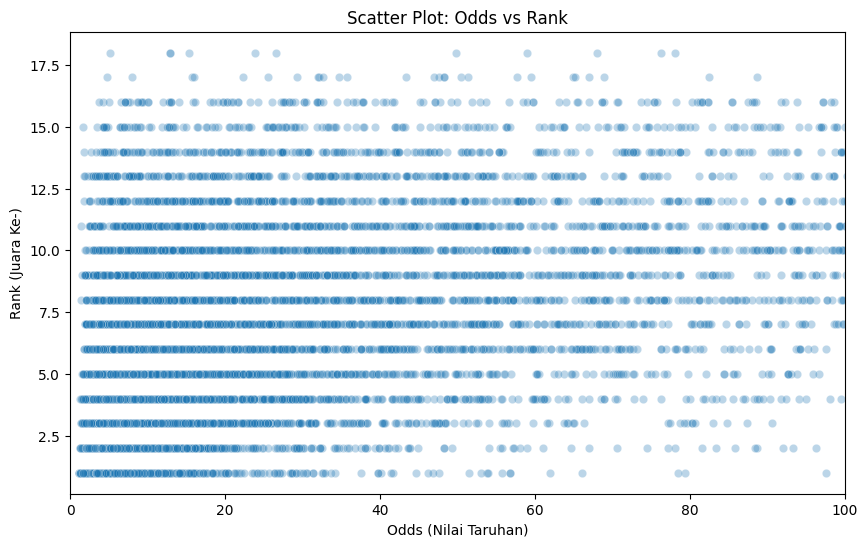

=== 3. Cek Korelasi Fitur Numerik ===


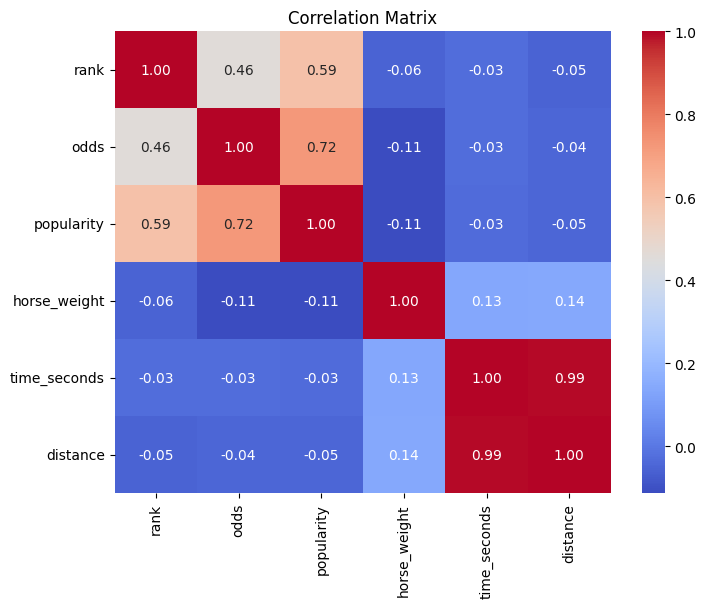

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Gunakan data bersih yang sudah disimpan
df = pd.read_csv('../data/processed/race_result_cleaned.csv')

print("=== 1. Cek Distribusi Target (Rank) ===")
# Apakah data Ranking tersebar merata?
plt.figure(figsize=(10, 5))
sns.countplot(x='rank', data=df)
plt.title("Distribusi Ranking (Jumlah Kuda di Tiap Posisi)")
plt.show()

print("=== 2. Cek Hubungan Odds vs Rank ===")
# Apakah kuda favorit (Odds rendah) cenderung juara?
# Kita ambil sampel 10.000 data saja biar plot tidak berat
subset = df.sample(10000)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='odds', y='rank', data=subset, alpha=0.3)
plt.xlim(0, 100) # Fokus pada odds 0-100
plt.title("Scatter Plot: Odds vs Rank")
plt.xlabel("Odds (Nilai Taruhan)")
plt.ylabel("Rank (Juara Ke-)")
plt.show()

print("=== 3. Cek Korelasi Fitur Numerik ===")
# Fitur apa yang paling berhubungan dengan Ranking?
corr_cols = ['rank', 'odds', 'popularity', 'horse_weight', 'time_seconds', 'distance']
corr_matrix = df[corr_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [2]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from sklearn.preprocessing import LabelEncoder

# Setup tqdm
tqdm.pandas()

# Load Data Bersih
# parse_dates penting agar kolom 'date' langsung jadi tipe datetime
df = pd.read_csv('../data/processed/race_result_cleaned.csv', parse_dates=['date'])

# PENTING: Urutkan data berdasarkan Kuda dan Tanggal
# Kita butuh urutan waktu yang benar untuk menghitung sejarah (masa lalu -> masa kini)
df = df.sort_values(by=['horse_name', 'date']).reset_index(drop=True)

print(f"Data Loaded: {len(df)} baris")
df.head(3)

d:\KULIAH\FINAL PROJECT\Project-UMA\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\HP\AppData\Local\Temp\ipykernel_19332\352310595.py:11: DtypeWarning: Columns (13,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/processed/race_result_cleaned.csv', parse_dates=['date'])


Data Loaded: 1611896 baris


,race_id,date,start_time,venue,holding_number,holding_days,race_name,race_class,race_type,grade_race_count,...,popularity,horse_weight,weight_change,prize,time_seconds,horse_name_eng,jockey_eng,owner_eng,trainer_eng,race_name_eng
0,201206010606,2012-01-21,12:50:00,Nakayama,1,6,3歳新馬,3yo Newcomer,NaN,NaN,...,13.0,454.0,0.0,90.0,102.6,Aiaiendebaa,Heiya Yuu,Saitou Takashi,Kojima Shigeyuki,3 Toshi Shinba
1,201205020805,2012-05-13,12:20:00,Tokyo,2,8,3歳未勝利,3yo Maiden,NaN,NaN,...,6.0,450.0,-4.0,NaN,125.8,Aiaiendebaa,Uiria,Saitou Takashi,Kojima Shigeyuki,3 Toshi Mishouri
2,201203020204,2012-06-17,11:40:00,Fukushima,2,2,3歳未勝利,3yo Maiden,NaN,NaN,...,9.0,444.0,-6.0,NaN,123.1,Aiaiendebaa,Tanaka Katsuharu,Saitou Takashi,Kojima Shigeyuki,3 Toshi Mishouri


In [4]:
print("--- Membuat Fitur: Rotation (Interval) ---")

# 1. Hitung tanggal balapan sebelumnya untuk setiap kuda
df['prev_date'] = df.groupby('horse_name')['date'].shift(1)

# 2. Hitung selisih hari (Date Sekarang - Date Sebelumnya)
df['rotation_days'] = (df['date'] - df['prev_date']).dt.days

# 3. Handling NaN (Balapan Pertama Kuda Tersebut)
# Kita isi dengan -1 atau 0. Mari pakai 0 untuk MVP.
df['rotation_days'] = df['rotation_days'].fillna(0)

# Cek hasil
print("Contoh Rotation Days:")
display(df[['date', 'horse_name', 'rotation_days']].head(10))

--- Membuat Fitur: Rotation (Interval) ---
Contoh Rotation Days:


,date,horse_name,rotation_days
0,2012-01-21,アイアイエンデバー,0.0
1,2012-05-13,アイアイエンデバー,113.0
2,2012-06-17,アイアイエンデバー,35.0
3,2012-07-15,アイアイエンデバー,28.0
4,2012-08-19,アイアイエンデバー,35.0
5,2012-09-02,アイアイエンデバー,14.0
6,2012-09-29,アイアイエンデバー,27.0
7,2012-11-18,アイアイエンデバー,50.0
8,2012-12-24,アイアイエンデバー,36.0
9,2013-01-12,アイアイエンデバー,19.0


In [5]:
print("--- Membuat Fitur: History (Lag Features) ---")

def create_lag_features(df):
    # Kelompokkan per kuda
    grp = df.groupby('horse_name')
    
    # A. Ranking Terakhir (Last Run)
    # Shift 1 = Ranking di balapan sebelumnya
    df['last_rank'] = grp['rank'].shift(1)
    
    # B. Ranking 3 Balapan Terakhir (Rata-rata)
    # Shift 1 dulu (hindari data bocor), baru ambil rata-rata 3 data ke belakang
    df['last_3_avg_rank'] = grp['rank'].transform(lambda x: x.shift(1).rolling(3).mean())
    
    # C. Total Balapan (Pengalaman)
    # Cumcount menghitung ini balapan ke-berapa buat si kuda
    df['race_count'] = grp.cumcount()
    
    return df

df = create_lag_features(df)

# Isi NaN (kuda debutan/baru lari sekali) dengan nilai default
# Misal: Jika tidak ada data ranking lalu, kita anggap ranking rata-rata (misal 10) atau -1
df['last_rank'] = df['last_rank'].fillna(18) # Anggap performa buruk jika belum ada data
df['last_3_avg_rank'] = df['last_3_avg_rank'].fillna(18)

print("Contoh History Features:")
display(df[['date', 'horse_name', 'rank', 'last_rank', 'last_3_avg_rank']].head(10))

--- Membuat Fitur: History (Lag Features) ---
Contoh History Features:


,date,horse_name,rank,last_rank,last_3_avg_rank
0,2012-01-21,アイアイエンデバー,4,18.0,18.000000
1,2012-05-13,アイアイエンデバー,14,4.0,18.000000
2,2012-06-17,アイアイエンデバー,8,14.0,18.000000
3,2012-07-15,アイアイエンデバー,10,8.0,8.666667
4,2012-08-19,アイアイエンデバー,2,10.0,10.666667
5,2012-09-02,アイアイエンデバー,1,2.0,6.666667
6,2012-09-29,アイアイエンデバー,8,1.0,4.333333
7,2012-11-18,アイアイエンデバー,11,8.0,3.666667
8,2012-12-24,アイアイエンデバー,4,11.0,6.666667
9,2013-01-12,アイアイエンデバー,2,4.0,7.666667


C:\Users\HP\AppData\Local\Temp\ipykernel_19332\1328060640.py:9: DtypeWarning: Columns (13,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/processed/race_result_cleaned.csv', parse_dates=['date'])


--- Memulai Running Style Clustering ---
Data valid untuk clustering: 695806 baris

--- Profil Cluster (Rata-rata Posisi) ---
   cluster_id   corner_1   corner_4   mean_pos
1           1   2.968661   2.826419   2.897540
2           2   5.503513   9.315849   7.409681
0           0   8.773431   6.068272   7.420852
3           3  12.381930  12.102874  12.242402

Mapping Label Otomatis: {1: 'Nige (Front)', 2: 'Senkou (Stalker)', 0: 'Sashi (Mid)', 3: 'Oikomi (Back)'}


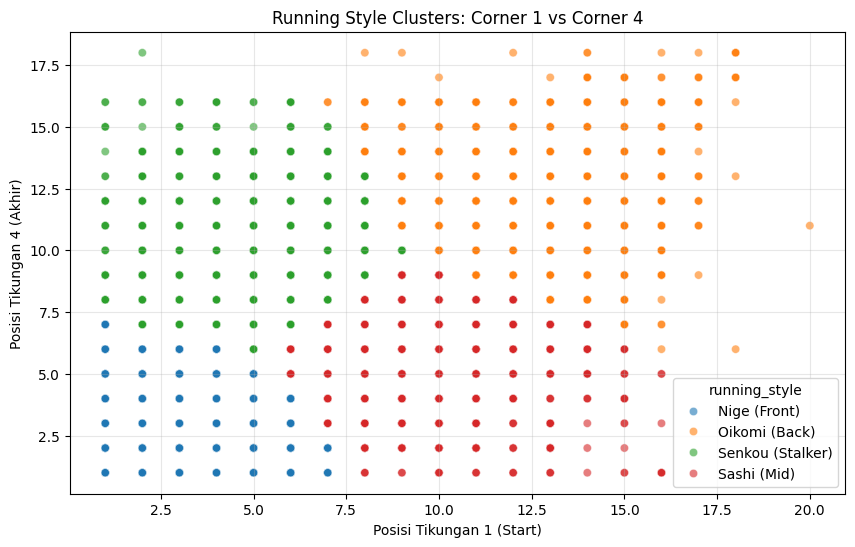


--- Hasil Akhir di Data Utama ---
running_style
Unknown             916090
Nige (Front)        263215
Sashi (Mid)         162101
Oikomi (Back)       151224
Senkou (Stalker)    119266
Name: count, dtype: int64


,horse_name,corner_1,corner_4,running_style
0,ワクセイ,NaN,1.0,Unknown
1,マツタカラオー,NaN,4.0,Unknown
2,カンキョウヘルス,NaN,3.0,Unknown
3,スズタカエース,NaN,2.0,Unknown
4,クリヤーパーマン,NaN,4.0,Unknown
5,ラガーヒム,NaN,6.0,Unknown
6,レミーファイヤー,NaN,7.0,Unknown
7,パンパードスキー,NaN,1.0,Unknown
8,サクラハゴロモ,NaN,3.0,Unknown
9,オカノアスティー,NaN,2.0,Unknown


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 1. Load Data Bersih (Gunakan data yang masih lengkap kolomnya)
df = pd.read_csv('../data/processed/race_result_cleaned.csv', parse_dates=['date'])

print("--- Memulai Running Style Clustering ---")

# 2. Persiapan Data untuk Clustering
# Kita butuh data posisi tikungan.
# Ambil kolom corner. Jika NaN (kuda tidak lewat tikungan/jarak pendek), kita isi dengan posisi finish (rank) atau mean.
# Strategi: Drop baris yang corner-nya kosong untuk Training K-Means, nanti kita predict sisanya (atau biarkan -1).
cluster_cols = ['corner_1', 'corner_4'] # Corner 1 (Start) dan Corner 4 (Sebelum Finish) paling krusial.

# Filter data yang valid untuk clustering (tidak boleh ada NaN di kolom corner)
df_cluster = df.dropna(subset=cluster_cols).copy()

print(f"Data valid untuk clustering: {len(df_cluster)} baris")

# 3. Standardisasi Data (PENTING untuk K-Means)
scaler = StandardScaler()
X = scaler.fit_transform(df_cluster[cluster_cols])

# 4. Jalankan K-Means (4 Cluster)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_cluster['cluster_id'] = kmeans.fit_predict(X)

# 5. Interpretasi Cluster (Memberi Label Manusia)
# Kita lihat rata-rata posisi tiap cluster untuk tahu dia tipe apa.
cluster_summary = df_cluster.groupby('cluster_id')[cluster_cols].mean().reset_index()
cluster_summary['mean_pos'] = (cluster_summary['corner_1'] + cluster_summary['corner_4']) / 2
cluster_summary = cluster_summary.sort_values('mean_pos') # Urutkan dari posisi terdepan (angka kecil)

print("\n--- Profil Cluster (Rata-rata Posisi) ---")
print(cluster_summary)

# Mapping Label berdasarkan urutan mean_pos:
# Cluster dengan mean_pos terendah (1-3) = Nige (Front)
# Cluster berikutnya = Senkou (Stalker)
# Cluster berikutnya = Sashi (Mid)
# Cluster dengan mean_pos tertinggi (belakang) = Oikomi (Back)

# Buat dictionary mapping otomatis
label_mapping = {}
labels = ['Nige (Front)', 'Senkou (Stalker)', 'Sashi (Mid)', 'Oikomi (Back)']

for i, cluster_id in enumerate(cluster_summary['cluster_id']):
    label_mapping[cluster_id] = labels[i]

print(f"\nMapping Label Otomatis: {label_mapping}")

# Terapkan Label ke DataFrame Cluster
df_cluster['running_style'] = df_cluster['cluster_id'].map(label_mapping)

# 6. Visualisasi Hasil (EDA Singkat)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='corner_1', y='corner_4', hue='running_style', data=df_cluster.sample(10000), alpha=0.6)
plt.title('Running Style Clusters: Corner 1 vs Corner 4')
plt.xlabel('Posisi Tikungan 1 (Start)')
plt.ylabel('Posisi Tikungan 4 (Akhir)')
plt.grid(True, alpha=0.3)
plt.show()

# 7. GABUNGKAN KEMBALI KE DATA UTAMA (Merge)
# Kita gabungkan hasil clustering ke tabel utama berdasarkan index
df['running_style'] = df_cluster['running_style']
# Isi NaN (yang tadi tidak ikut clustering) dengan 'Unknown'
df['running_style'] = df['running_style'].fillna('Unknown')

# Cek hasil di tabel utama
print("\n--- Hasil Akhir di Data Utama ---")
print(df['running_style'].value_counts())
display(df[['horse_name', 'corner_1', 'corner_4', 'running_style']].head(10))

# 8. Encoding untuk Model (Opsional, jika mau dipakai training langsung)
# Ubah string 'Nige', 'Senkou' jadi angka 0, 1, 2, 3
style_encoder = {v: k for k, v in enumerate(labels)}
style_encoder['Unknown'] = -1
df['running_style_id'] = df['running_style'].map(style_encoder)

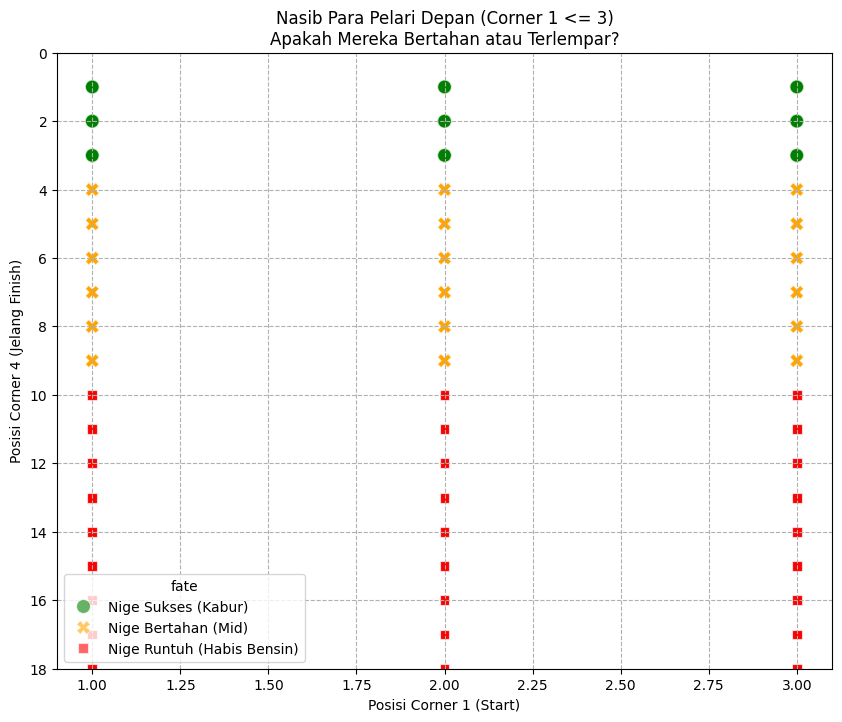

Contoh Kuda yang Start 1 tapi Terlempar ke >10 (Nige Runtuh):


,date,horse_name_eng,race_name_eng,corner_1,corner_4,rank
1589871,2021-07-31,Kikunodiin,3 Toshi Mishouri,3.0,10.0,15
1585978,2021-07-31,Pikkuapetaru,3 Toshi Mishouri,1.0,13.0,14
1585736,2021-07-24,Vikutorion,3 Toshi Ijou 1 Kachi Kurasu,3.0,12.0,13
1585550,2021-07-18,Tennoryuugi,3 Toshi Mishouri,2.0,16.0,16
1611895,2021-07-18,Kiwami,3 Toshi Ijou 1 Kachi Kurasu,3.0,12.0,16


In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter Data: Ambil hanya kuda yang Start-nya agresif (Corner 1 <= 3)
# Ini adalah grup "Calon Nige" (termasuk Katsuragi Ace, Silence Suzuka, Twin Turbo)
nige_candidates = df[df['corner_1'] <= 3].copy()

# Kita beri label manual untuk visualisasi ini
def get_nige_fate(row):
    if row['corner_4'] <= 3:
        return 'Nige Sukses (Kabur)' # Start Depan, Akhir Depan (1 -> 1)
    elif row['corner_4'] >= 10:
        return 'Nige Runtuh (Habis Bensin)' # Start Depan, Terlempar (1 -> 15)
    else:
        return 'Nige Bertahan (Mid)' # Start Depan, Mundur dikit (1 -> 5)

nige_candidates['fate'] = nige_candidates.apply(get_nige_fate, axis=1)

# Plotting
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=nige_candidates,
    x='corner_1', 
    y='corner_4', 
    hue='fate',
    palette={'Nige Sukses (Kabur)': 'green', 'Nige Runtuh (Habis Bensin)': 'red', 'Nige Bertahan (Mid)': 'orange'},
    style='fate',
    s=100, # Ukuran titik
    alpha=0.6
)

plt.title('Nasib Para Pelari Depan (Corner 1 <= 3)\nApakah Mereka Bertahan atau Terlempar?')
plt.xlabel('Posisi Corner 1 (Start)')
plt.ylabel('Posisi Corner 4 (Jelang Finish)')
plt.ylim(18, 0) # PENTING: Kita balik sumbu Y agar Ranking 1 ada di ATAS grafis
plt.grid(True, linestyle='--')
plt.show()

# Cek Siapa saja yang "Runtuh"?
print("Contoh Kuda yang Start 1 tapi Terlempar ke >10 (Nige Runtuh):")
collapsed_nige = nige_candidates[nige_candidates['fate'] == 'Nige Runtuh (Habis Bensin)'].sort_values('date', ascending=False)
display(collapsed_nige[['date', 'horse_name_eng', 'race_name_eng', 'corner_1', 'corner_4', 'rank']].head(5))

In [40]:
def classify_running_style_rule_based(row):
    # 1. Deteksi MAKURI dulu (Spesial)
    # Jika start belakang, tapi finish tikungan depan
    if row['corner_1'] >= 10 and row['corner_4'] <= 4:
        return 'Makuri (Long Spurt)'
        
    # 2. Klasifikasi Standar berdasarkan CORNER 1 (Niat Awal)
    c1 = row['corner_1']
    
    if c1 == 1:
        return 'Nige (Front)'      # Selalu ingin memimpin
    elif c1 <= 4:
        return 'Senkou (Stalker)'  # Menguntit di depan
    elif c1 <= 10:
        return 'Sashi (Mid)'       # Menunggu di tengah
    else:
        return 'Oikomi (Back)'     # Santai di belakang

# Terapkan
df['running_style'] = df.apply(classify_running_style_rule_based, axis=1)

In [11]:
# Keyword pencarian 
keyword = "ダイワドンクール"

# Filter DataFrame
# na=False agar tidak error jika ada nama yang kosong
search_results = df_cluster[df_cluster['horse_name'].str.contains(keyword, case=False, na=False)]

# Urutkan berdasarkan tanggal balapan
search_results = search_results.sort_values('date')

# Tampilkan kolom-kolom penting
cols_to_show = ['date', 'race_name_eng','race_name_eng','race_class','owner_eng', 'horse_name_eng','running_style','corner_1','corner_4', 'jockey_eng', 'trainer_eng','rank', 'odds', 'popularity']

print(f"Ditemukan {len(search_results)} data balapan dengan nama '{keyword}':")
display(search_results[cols_to_show])

Ditemukan 6 data balapan dengan nama 'ダイワドンクール':


,date,race_name_eng,race_name_eng,race_class,owner_eng,horse_name_eng,running_style,corner_1,corner_4,jockey_eng,trainer_eng,rank,odds,popularity
200525,1991-01-12,4 Toshi Mishouri,4 Toshi Mishouri,4yo Maiden,Yamato Shouji,Daiwadonkuuru,Senkou (Stalker),5.0,6.0,Sawa Akinori,Ogata Moritsugu,1,8.8,5.0
201245,1991-02-23,Suisen Shou,Suisen Shou,4yo Under 5M,Yamato Shouji,Daiwadonkuuru,Senkou (Stalker),5.0,7.0,Tanaka Katsuharu,Ogata Moritsugu,1,8.9,5.0
202292,1991-03-17,Wakaba Suteekusu,Wakaba Suteekusu,4yo Open,Yamato Shouji,Daiwadonkuuru,Senkou (Stalker),6.0,10.0,Tanaka Katsuharu,Ogata Moritsugu,10,39.2,7.0
194302,1991-08-18,Nihonkai Suteekusu,Nihonkai Suteekusu,4yo+ Under 9M,Yamato Shouji,Daiwadonkuuru,Nige (Front),3.0,4.0,Eda Teruo,Ogata Moritsugu,11,15.6,7.0
194770,1991-09-01,Sado Suteekusu,Sado Suteekusu,4yo+ Under 9M,Yamato Shouji,Daiwadonkuuru,Senkou (Stalker),5.0,8.0,Eda Teruo,Ogata Moritsugu,6,14.0,6.0
204245,1991-09-22,Inubouzaki Tokubetsu,Inubouzaki Tokubetsu,4yo+ Under 9M,Yamato Shouji,Daiwadonkuuru,Nige (Front),4.0,2.0,Eda Teruo,Ogata Moritsugu,8,26.5,7.0


In [9]:
import pandas as pd

# 1. Filter Kuda dengan Gaya Lari 'Stalker' (Case Insensitive)
# Pastikan nama kolom gaya lari sesuai (misal: 'running_style' atau 'leg_type')
# Kita gunakan .str.contains agar bisa menangkap variasi seperti "Stalker", "Sashi", atau "Betweener"
stalker_horses = df_cluster[
    df_cluster['running_style'].str.contains('Stalker', case=False, na=False)
]

# 2. Filter Hanya yang Juara 1
# Kita konversi kolom 'rank' ke numerik dulu untuk menghindari error (misal ada data "1(降)")
stalker_horses['rank_numeric'] = pd.to_numeric(stalker_horses['rank'], errors='coerce')
stalker_winners = stalker_horses[stalker_horses['rank_numeric'] == 1]

# 3. Hitung Jumlah Kemenangan per Kuda
# Kita grupkan berdasarkan nama kuda dan hitung kemunculannya
top_stalkers = stalker_winners.groupby(['horse_name', 'horse_name_eng']) \
    .size() \
    .reset_index(name='total_wins') \
    .sort_values('total_wins', ascending=False)

# 4. Tampilkan 10 Kuda Stalker Teratas
print(f"Ditemukan {len(stalker_winners)} kemenangan oleh kuda tipe Stalker.")
print("Top 10 Kuda Stalker dengan kemenangan terbanyak:")
display(top_stalkers.head(10))

# --- Opsional: Lihat detail kemenangan kuda peringkat 1 ---
if not top_stalkers.empty:
    top_horse_name = top_stalkers.iloc[0]['horse_name']
    print(f"\nDetail kemenangan untuk: {top_horse_name}")
    
    # Ambil detail balapan kuda tersebut
    detail_top = stalker_winners[stalker_winners['horse_name'] == top_horse_name].sort_values('date')
    cols_to_show = ['date', 'race_name_eng', 'race_class', 'jockey_eng', 'popularity', 'odds']
    display(detail_top[cols_to_show].head(5))

Ditemukan 1135 kemenangan oleh kuda tipe Stalker.
Top 10 Kuda Stalker dengan kemenangan terbanyak:


C:\Users\HP\AppData\Local\Temp\ipykernel_19332\996609707.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stalker_horses['rank_numeric'] = pd.to_numeric(stalker_horses['rank'], errors='coerce')


,horse_name,horse_name_eng,total_wins
792,ベストアルバム,Besutoarubamu,3
38,アドマイヤデウス,Adomaiyadeusu,2
39,アドマイヤバラード,Adomaiyabaraado,2
493,ダイタクアスリート,Daitakuasuriito,2
172,カフジプリンス,Kafujipurinsu,2
199,キングストーン,Kingusutoon,2
1096,ヴィータローザ,Viitarooza,2
1097,ヴィーヴァミラコロ,Viivamirakoro,2
500,ダイワドンクール,Daiwadonkuuru,2
352,シルクシュナイダー,Shirukushunaidaa,2



Detail kemenangan untuk: ベストアルバム


,date,race_name_eng,race_class,jockey_eng,popularity,odds
698065,2002-09-22,2 Toshi Mishouri,2yo Maiden,Takahashi Akira,1.0,2.6
752031,2003-08-24,Saikai Shou,3yo+ Under 10M,Watanabe Kunihiko,2.0,3.8
832449,2005-02-05,Moto Hata Tokubetsu,4yo+ Under 10M,Watanabe Kunihiko,2.0,4.1


In [46]:
# Keyword pencarian 
keyword = "メジロマックイーン"

# Filter DataFrame
# na=False agar tidak error jika ada nama yang kosong
search_results = df[df['horse_name'].str.contains(keyword, case=False, na=False)]

# Urutkan berdasarkan tanggal balapan
search_results = search_results.sort_values('date')

# Tampilkan kolom-kolom penting
cols_to_show = ['date', 'race_name_eng','race_name_eng','race_class','owner_eng', 'horse_name_eng','running_style', 'jockey_eng', 'trainer_eng','rank', 'odds', 'popularity']

print(f"Ditemukan {len(search_results)} data balapan dengan nama '{keyword}':")
display(search_results[cols_to_show])

Ditemukan 21 data balapan dengan nama 'メジロマックイーン':


,date,race_name_eng,race_name_eng,race_class,owner_eng,horse_name_eng,running_style,jockey_eng,trainer_eng,rank,odds,popularity
177616,1990-02-03,4 Toshi Shinba,4 Toshi Shinba,4yo Newcomer,Mejiro Shouji,Mejiromakkuiin,Senkou (Stalker),Muramoto Yoshiyuki,Ikee Yasurou,1,3.3,2.0
178519,1990-02-25,Yukiyanagi Shou,Yukiyanagi Shou,4yo Under 5M,Mejiro Shouji,Mejiromakkuiin,Sashi (Mid),Muramoto Yoshiyuki,Ikee Yasurou,2,2.2,1.0
173801,1990-05-12,Ayame Shou,Ayame Shou,4yo Under 5M,Mejiro Shouji,Mejiromakkuiin,Senkou (Stalker),Muramoto Yoshiyuki,Ikee Yasurou,3,1.7,1.0
149665,1990-09-02,Watarishima Tokubetsu,Watarishima Tokubetsu,4yo+ Under 5M,Mejiro Shouji,Mejiromakkuiin,Senkou (Stalker),Uchida Kouichi,Ikee Yasurou,2,1.7,1.0
149996,1990-09-16,Kikonai Tokubetsu,Kikonai Tokubetsu,4yo+ Under 5M,Mejiro Shouji,Mejiromakkuiin,Nige (Front),Uchida Kouichi,Ikee Yasurou,1,1.2,1.0
150203,1990-09-23,Oonuma Suteekusu,Oonuma Suteekusu,4yo+ Under 9M,Mejiro Shouji,Mejiromakkuiin,Senkou (Stalker),Uchida Kouichi,Ikee Yasurou,1,4.1,1.0
174396,1990-10-13,Arashiyama Suteekusu,Arashiyama Suteekusu,4yo+ Under 15M,Mejiro Shouji,Mejiromakkuiin,Sashi (Mid),Uchida Kouichi,Ikee Yasurou,2,2.4,1.0
175418,1990-11-04,Kikkashou,Kikkashou,4yo Open,Mejiro Shouji,Mejiromakkuiin,Sashi (Mid),Uchida Kouichi,Ikee Yasurou,1,7.8,4.0
206491,1991-03-10,Hanshindaishouten,Hanshindaishouten,4yo+ Open,Mejiro Shouji,Mejiromakkuiin,Sashi (Mid),Taketoyo,Ikee Yasurou,1,1.2,1.0
214351,1991-04-28,Tennoushou ( Haru ),Tennoushou ( Haru ),4yo+ Open,Mejiro Shouji,Mejiromakkuiin,Sashi (Mid),Taketoyo,Ikee Yasurou,1,1.7,1.0


In [21]:
import numpy as np

# 1. Filter dulu: Buang data yang gayanya 'Unknown'
# Kita hanya ingin menilai konsistensi dari balapan yang datanya LENGKAP
df_valid_style = df[df['running_style'] != 'Unknown'].copy()

# 2. Hitung Statistik Gaya Lari per Kuda (dari data valid saja)
horse_style_stats = df_valid_style.groupby('horse_name')['running_style'].agg(
    total_valid_races='count',
    unique_styles='nunique',
    most_common_style=lambda x: x.mode()[0]
).reset_index()

# 3. Cari Kuda 'Robot' (Sangat Konsisten)
# Syarat: 
# - Minimal 10 race VALID (bukan total race, tapi race yang ada datanya)
# - Hanya 1 jenis gaya lari (Unique == 1)
consistent_horses = horse_style_stats[
    (horse_style_stats['total_valid_races'] >= 10) & 
    (horse_style_stats['unique_styles'] == 1)
]

print(f"Ditemukan {len(consistent_horses)} kuda yang 100% konsisten (Valid Data).")

# 4. AMBIL 1 SAMPEL ACAK & TAMPILKAN
if len(consistent_horses) > 0:
    sample_horse = consistent_horses.sample(1)['horse_name'].values[0]
    
    print(f"\n=== SAMPEL KUDA KONSISTEN: {sample_horse} ===")
    
    # Tampilkan Data
    cols_show = ['date', 'race_name_eng', 'surface', 'distance', 'corner_1', 'corner_4', 'running_style', 'rank','horse_name_eng']
    # Kita ambil dari df utama biar kelihatan kalau ada race yang 'Unknown' terselip
    history = df[df['horse_name'] == sample_horse][cols_show].sort_values('date')
    display(history)
    
    style = consistent_horses[consistent_horses['horse_name'] == sample_horse]['most_common_style'].values[0]
    print(f"\nAnalisis: Kuda {sample_horse} adalah spesialis gaya '{style}' sejati!")
else:
    print("Tidak ada kuda yang memenuhi kriteria.")

Ditemukan 193 kuda yang 100% konsisten (Valid Data).

=== SAMPEL KUDA KONSISTEN: ゲイリーエアラ ===


,date,race_name_eng,surface,distance,corner_1,corner_4,running_style,rank,horse_name_eng
410389,1996-11-30,3 Toshi Shinba,Dirt,1800,2.0,2.0,Nige (Front),5,Geiriieara
452912,1997-09-14,4 Toshi Mishouri,Dirt,1800,2.0,2.0,Nige (Front),1,Geiriieara
446504,1997-10-05,4 Toshi Ijou 500 Man Shita,Dirt,1600,NaN,3.0,Unknown,8,Geiriieara
437989,1997-11-02,Haramachi Tokubetsu,Dirt,1700,5.0,4.0,Nige (Front),7,Geiriieara
489866,1998-06-14,4 Toshi Ijou 500 Man Shita,Dirt,1400,NaN,2.0,Unknown,2,Geiriieara
479115,1998-06-27,4 Toshi Ijou 500 Man Shita,Dirt,1700,2.0,2.0,Nige (Front),3,Geiriieara
479895,1998-07-12,4 Toshi Ijou 500 Man Shita,Dirt,1700,2.0,2.0,Nige (Front),4,Geiriieara
475990,1998-09-13,4 Toshi Ijou 500 Man Shita,Dirt,1700,3.0,2.0,Nige (Front),7,Geiriieara
476507,1998-09-27,Kushiro Tokubetsu,Dirt,1700,1.0,1.0,Nige (Front),2,Geiriieara
490508,1998-10-24,4 Toshi Ijou 500 Man Shita,Dirt,1600,NaN,1.0,Unknown,1,Geiriieara



Analisis: Kuda ゲイリーエアラ adalah spesialis gaya 'Nige (Front)' sejati!


In [7]:
print("--- Label Encoding (Kategori -> Angka) ---")

# Daftar kolom kategori yang perlu diubah
cat_cols = ['venue', 'weather', 'surface', 'course_direction', 'race_class', 'sex']
# Note: horse_name, jockey, trainer biarkan dulu (bisa pakai ID atau target encoding nanti)

le = LabelEncoder()

for col in cat_cols:
    # Isi NaN dengan 'Unknown' dulu biar encoder tidak error
    df[col] = df[col].fillna('Unknown')
    
    # Fit & Transform
    df[col + '_id'] = le.fit_transform(df[col].astype(str))
    print(f" > {col} di-encode menjadi {col}_id")

# Cek hasil
display(df[['venue', 'venue_id', 'weather', 'weather_id']].head())

--- Label Encoding (Kategori -> Angka) ---
 > venue di-encode menjadi venue_id
 > weather di-encode menjadi weather_id
 > surface di-encode menjadi surface_id
 > course_direction di-encode menjadi course_direction_id
 > race_class di-encode menjadi race_class_id
 > sex di-encode menjadi sex_id


,venue,venue_id,weather,weather_id
0,Nakayama,6,Light Rain,1
1,Tokyo,9,Sunny,5
2,Fukushima,1,Cloudy,0
3,Niigata,7,Rain,3
4,Niigata,7,Sunny,5


In [9]:
print("--- Simpan Data Siap Model ---")

# Pilih kolom-kolom yang akan dipakai training
# Kita buang kolom teks mentah, ambil ID-nya saja, plus fitur numerik baru
feature_cols = [
    'race_id', 'date', 'rank', # Metadata Penting
    'odds', 'popularity', 'horse_weight', 'distance', 'horse_no', 'frame_no', # Fitur Asli Numerik
    'rotation_days', 'last_rank', 'last_3_avg_rank', 'race_count', # Fitur Buatan (Engineered)
    'venue_id', 'weather_id', 'surface_id', 'course_direction_id', 'race_class_id', 'sex_id' # Fitur Kategori ID
]

df_model = df[feature_cols].copy()

# Simpan
output_file = '../data/processed/master_data_modeled.csv'
df_model.to_csv(output_file, index=False)

print(f"File Modeling tersimpan: {output_file}")
print(f"Dimensi Akhir: {df_model.shape}")

--- Simpan Data Siap Model ---
File Modeling tersimpan: ../data/processed/master_data_modeled.csv
Dimensi Akhir: (1611896, 19)
